# From Raw Text to Social Network Analysis
In this guide we'll take a set of documents, extract entities from within them, and develop a social network based on entity document co-occurrence. This can be a useful approach for getting a sense of which entities exist in a set of documents and how those entities might be related. I'll talk more about using document co-occurrence as the mechanism for drawing an edge in a social network graph later.

This guide relies on two primary pieces of software for natural language processing. I'll be using the [Natural Language Toolkit](http://www.nltk.org/) for text pre-processing and [Stanford Core NLP](https://stanfordnlp.github.io/CoreNLP/) running on Docker for entity extraction.

## Getting Set Up
First, we need to get Core NLP running on Docker. If you're not familiar with Docker, that's ok! It's a really easy to use containerization service. The concept is that anywhere you can run docker you can run a docker container. Period. No need to worry about dependency management, just get docker running and pull down the container you need. Easy.

### Installing Docker
Docker has great instructions for installing Docker. I'm using a Mac so I followed their [Mac OSX Docker installation guide](https://docs.docker.com/docker-for-mac/install/). If you're using Windows check out their [Windows install guide.](https://docs.docker.com/docker-for-windows/install/). If you're using Linux I'm pretty sure you'll be able to get Docker installed on your own.

To verify the installation was successful go to your command line and try running:

```
docker ps
```

You should an empty the docker container listing looks like (I truncated a couple columns, but you get the idea):
```
CONTAINER ID        IMAGE               COMMAND             CREATED
```      
If this isn't empty you already had docker running with a container. If you are not able to run the `docker` or `docker ps` commands from your command line, **STOP**. You need to get this installed before continuing.

### Installing the Core NLP container
This part is pretty easy. You just need to run the following command at your command line:
```
docker run -p 9000:9000 --name coreNLP --rm -i -t motiz88/corenlp
```
This will pull motiz88's Docker port of Core NLP and run it using port 9000. This means that port 9000 from the container will be forwarded to port 9000 on your localhost (your computer). So, you can access the Core NLP API over `http://localhost:9000`. Note that this is a fairly large container so it may take a few minutes to download and install.

To make sure that the server is running, in your browser go to http://localhost:9000. You should see:
![Stanford Core NLP Server](core_nlp_server.png "Core NLP Server")

If you don't, don't move forward until you can verify the Core NLP server is running. You might try `docker ps` to see if the container is listed. If it is, you can scope out the logs with `docker logs coreNLP`. If it *is* running feel free to play around with the server UI. Input some text to get a feel for how it works!

### Validating Core NLP works
To use Core NLP Server, we are going to leverage the `pycorenlp` Python wrapper which can be `pip install`ed. 

In [5]:
from pycorenlp import StanfordCoreNLP
nlp = StanfordCoreNLP('http://localhost:9000')

In [166]:
text = ("Bill and Ted are excellent! "
        "Pusheen Smith and Jillian Marie walked along the beach. "
        "Pusheen wanted to surf, but fell off the surfboard. "
        "They are both friends with Jean Claude van Dam, Sam's neighbor.")
output = nlp.annotate(text, properties={
  'annotators': 'ner',
  'outputFormat': 'json'
  })

In [167]:
def proc_sentence(tokens):
    """
    Takes as input a set of tokens from Stanford Core NLP output and returns 
    the set of peoplefound within the sentence. This relies on the fact that
    named entities which are contiguous within a sentence should be part of 
    the same name. For example, in the following:
    [
        {'word': 'Brandon', 'ner': 'PERSON'},
        {'word': 'Rose', 'ner': 'PERSON'},
        {'word': 'eats', 'ner': 'O'},
        {'word': 'bananas', 'ner': 'O'}
    ]
    we can safely assume that the contiguous PERSONs Brandon + Rose are part of the 
    same named entity, Brandon Rose.
    """
    people = set()
    token_count = 0
    for i in range(len(tokens)):
        if token_count < len(tokens):
            person = ''
            token = tokens[token_count]
            if token['ner'] == 'PERSON':
                person += token['word'].lower()
                checking = True
                while checking == True:
                    if token_count + 1 < len(tokens):
                        if tokens[token_count + 1]['ner'] == 'PERSON':
                            token_count += 1
                            person += ' {}'.format(tokens[token_count]['word'].lower())
                        else:
                            checking = False
                            token_count += 1
                    else:
                        checking = False
                        token_count += 1
            else:
                token_count += 1
            if person != '':
                people.add(person)
    return people

In [168]:
for sent in output['sentences']:
    people = proc_sentence(sent['tokens'])
    print(people)

set([u'bill', u'ted'])
set([u'pusheen smith', u'jillian marie'])
set([u'pusheen'])
set([u'jean claude van dam', u'sam'])


In [165]:
len(output['sentences'])

1

In [151]:
people

{u'jean claude van dam', u'jillian marie', u'pusheen smith', u'sam'}

In [43]:
def extract_people(output):
    """
    Process Core NLP output and return the named entities which are people (in lowercase form).
    """
    people = set()
    for sentence in output['sentences']:
        for token in sentence['tokens']:
            if token['ner'] == 'PERSON':
                people.add(token['word'].lower())
    return people

In [44]:
extract_people(output)

{u'jillian', u'marie', u'pusheen', u'smith'}

In [20]:
from fuzzywuzzy.process import dedupe as fuzzy_dedupe

Note that you may be asked to install `python-Levenshtein` to speed up fuzzywuzzy; you can do this with `pip install python-Levenshtein`.

### Working with MITIE

First we're going to define a basic function that helps us talk with MITIE. Note that the raw output from MITIE is somewhat tricky to work with, since you are actually provided the character locations for each token. Let's start with an example document.

In [13]:
sample = 'A Pegasus Airlines plane landed at an Istanbul airport Friday after a passenger " said that there was a bomb on board " and wanted the plane to land in Sochi , Russia , the site of the Winter Olympics , said officials with Turkey \'s Transportation Ministry . Meredith Vieira will become the first woman to host Olympics primetime coverage on her own when she fills on Friday night for the ailing Bob Costas , who is battling a continuing eye infection . " It \'s an honor to fill in for him , " Vieira said on TODAY Friday . " You think about the Olympics , and you think the athletes and then Bob Costas . " " Bob \'s eye issue has improved but he \'s not quite ready to do the show , " NBC Olympics Executive Producer Jim Bell told TODAY . com from Sochi on Thursday . From wikipedia we learn that Josiah Franklin \'s son , Benjamin Franklin was born in Boston . Since wikipedia allows anyone to edit it , you could change the entry to say that Philadelphia is the birthplace of Benjamin Franklin . However , that would be a bad edit since Benjamin Franklin was definitely born in Boston .'
print sample

A Pegasus Airlines plane landed at an Istanbul airport Friday after a passenger " said that there was a bomb on board " and wanted the plane to land in Sochi , Russia , the site of the Winter Olympics , said officials with Turkey 's Transportation Ministry . Meredith Vieira will become the first woman to host Olympics primetime coverage on her own when she fills on Friday night for the ailing Bob Costas , who is battling a continuing eye infection . " It 's an honor to fill in for him , " Vieira said on TODAY Friday . " You think about the Olympics , and you think the athletes and then Bob Costas . " " Bob 's eye issue has improved but he 's not quite ready to do the show , " NBC Olympics Executive Producer Jim Bell told TODAY . com from Sochi on Thursday . From wikipedia we learn that Josiah Franklin 's son , Benjamin Franklin was born in Boston . Since wikipedia allows anyone to edit it , you could change the entry to say that Philadelphia is the birthplace of Benjamin Franklin . How

To use MITIE's pre-trained named entity recognition (NER) model I would run

In [14]:
tokens = tokenize(sample)
entities = ner_model.extract_entities(tokens)
print entities

[(xrange(1, 3), 'ORGANIZATION'), (xrange(7, 8), 'LOCATION'), (xrange(30, 31), 'LOCATION'), (xrange(32, 33), 'LOCATION'), (xrange(44, 45), 'LOCATION'), (xrange(46, 48), 'ORGANIZATION'), (xrange(49, 51), 'PERSON'), (xrange(58, 59), 'MISC'), (xrange(73, 75), 'PERSON'), (xrange(96, 97), 'PERSON'), (xrange(107, 108), 'MISC'), (xrange(116, 118), 'PERSON'), (xrange(121, 122), 'PERSON'), (xrange(139, 141), 'ORGANIZATION'), (xrange(143, 145), 'PERSON'), (xrange(150, 151), 'LOCATION'), (xrange(159, 161), 'PERSON'), (xrange(164, 166), 'PERSON'), (xrange(169, 170), 'LOCATION'), (xrange(187, 188), 'LOCATION'), (xrange(192, 194), 'PERSON'), (xrange(204, 206), 'PERSON'), (xrange(210, 211), 'LOCATION')]


This returns a list of tuples for each entity where the first item is the `xrange` of the entity and the second item is the entity type. Since we actually want to work with the entity itself, we need to conver the xrange locations into the actual token, which is accomplished by the `talk_to_mitie` function below.

In [3]:
def talk_to_mitie(text, ner_model=ner_model):
    # Function that accepts text to MITIE and gets entities and HTML in response
    text = text.encode("utf-8")
    tokens = tokenize(text)
    tokens.append(' x ')
    entities = ner_model.extract_entities(tokens)
    out = []
    for e in entities:
        range = e[0]
        tag = e[1]
        entity_text = str(" ").join(tokens[i] for i in range)
        out.append({u'tag': unicode(tag), u'text': entity_text})
    return {"entities": out}

Now, we can get a lot more useful information. The output here is a JSON object of entities where the key is `entities` and the value is a list of json object entity `tag`, `text` pairs.

In [16]:
talk_to_mitie(sample)

{'entities': [{u'tag': u'ORGANIZATION', u'text': 'Pegasus Airlines'},
  {u'tag': u'LOCATION', u'text': 'Istanbul'},
  {u'tag': u'LOCATION', u'text': 'Sochi'},
  {u'tag': u'LOCATION', u'text': 'Russia'},
  {u'tag': u'LOCATION', u'text': 'Turkey'},
  {u'tag': u'ORGANIZATION', u'text': 'Transportation Ministry'},
  {u'tag': u'PERSON', u'text': 'Meredith Vieira'},
  {u'tag': u'MISC', u'text': 'Olympics'},
  {u'tag': u'PERSON', u'text': 'Bob Costas'},
  {u'tag': u'PERSON', u'text': 'Vieira'},
  {u'tag': u'MISC', u'text': 'Olympics'},
  {u'tag': u'PERSON', u'text': 'Bob Costas'},
  {u'tag': u'PERSON', u'text': 'Bob'},
  {u'tag': u'ORGANIZATION', u'text': 'NBC Olympics'},
  {u'tag': u'PERSON', u'text': 'Jim Bell'},
  {u'tag': u'LOCATION', u'text': 'Sochi'},
  {u'tag': u'PERSON', u'text': 'Josiah Franklin'},
  {u'tag': u'PERSON', u'text': 'Benjamin Franklin'},
  {u'tag': u'LOCATION', u'text': 'Boston'},
  {u'tag': u'LOCATION', u'text': 'Philadelphia'},
  {u'tag': u'PERSON', u'text': 'Benjamin 

Notice that 'Benjamin Franklin' was found multiple times. This presents a problem: MITIE can find entities for us, but it can't detect whether that entity has already occurred in a document. This is a problem known as **entity resolution**. I won't discuss in detail the various approaches for entity resolution, however I will present one solution. Since we will be looking for entities on a per document basis, if two entities are of the same type and similarly spelled we should reconcile them to the same entity.

To help with this, we'll use something called [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy). Specifically, we'll use the fuzzy deduplication function (shameless plug, this is something I contributed to the fuzzywuzzy project). We can use the defaults, however you are welcome to tune the [parameters](https://github.com/seatgeek/fuzzywuzzy/blob/master/fuzzywuzzy/process.py#L167-L193). As an example of what fuzzy deduping is, let's try it:

In [5]:
contains_dupes = ['Frodo Baggin', 'Frodo Baggins', 'F. Baggins', 'Samwise G.', 'Gandalf', 'Bilbo Baggins']
print contains_dupes

['Frodo Baggin', 'Frodo Baggins', 'F. Baggins', 'Samwise G.', 'Gandalf', 'Bilbo Baggins']


Here we have a list containing duplicates with slight spelling variations. Using fuzzywuzzy's dedupe function we can take care of this pretty easily:

In [6]:
fuzzy_dedupe(contains_dupes)

['Frodo Baggins', 'Samwise G.', 'Bilbo Baggins', 'Gandalf']

That looks like a useful list of entities to me! Now, I'll incorporate fuzzy deduplication into a function called `get_entities`

In [7]:
def get_entities(text):
    
    # get MITIE output
    model_output = talk_to_mitie(text)
    
    # generate empty lists
    people = []
    places = []
    orgs = []
    
    # iterate over model output
    for item in model_output['entities']:
        if item['tag'] == 'ORGANIZATION':
            orgs.append(item['text'])

        if item['tag'] == 'PERSON':
            people.append(item['text'])

        if item['tag'] == 'LOCATION':
            places.append(item['text'])

    # use fuzzywuzzy to fuzzy deduplicate the entity type lists
    people = fuzzy_dedupe(people)
    places = fuzzy_dedupe(places)
    orgs = fuzzy_dedupe(orgs)

    entities = {'people': people, 'places': places, 'orgs': orgs}

    return entities

If I try `get_entities` on the sample from earlier we get some pretty solid results!

In [20]:
get_entities(sample)

{'orgs': ['Pegasus Airlines', 'Transportation Ministry', 'NBC Olympics'],
 'people': ['Meredith Vieira',
  'Jim Bell',
  'Josiah Franklin',
  'Bob Costas',
  'Benjamin Franklin'],
 'places': ['Turkey', 'Istanbul', 'Boston', 'Philadelphia', 'Sochi', 'Russia']}

## Getting some data
For this guide I'll be using a selection of news articles. To get the articles, I'm using [Newspaper](https://github.com/codelucas/newspaper). I'm going to scrape about 100 articles off [Ars Technica](http://arstechnica.com/) which I don't really expect to contain much social network information, but it's easy enough data to obtain. In the future I might try to obtain a set of news articles on a particular topic (e.g. pharmaceuticals).

In [3]:
import requests
import json
import newspaper

In [4]:
cnn = newspaper.build('http://cnn.com')

In [5]:
corpus = []
count = 0
for article in cnn.articles[:100]:
    article.download()
    article.parse()
    text = article.text
    corpus.append(text)
    print count
    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
with open('corpus.txt', 'a') as fp:
    count = 0
    for item in corpus:
        loaded = item.encode('utf-8')
        loaded_j = {count: loaded}
        fp.write(json.dumps(loaded_j) + '\n')
        count += 1
    fp.close()

We can read back in the data we wrote to disk in the format of:
```
data[index]: {'article': 'article text'}
```
where the index is the order we read in the data.

In [10]:
data = {}
with open('corpus.txt', 'r') as fp:
    for line in fp:
        item = json.loads(line)
        key = int(item.keys()[0])
        value = item.values()[0].encode('ascii','ignore')
        data[key] = {'article':value}
    fp.close()

Now let's get the entities for each of the articles we've grabbed. We'll write the results back to the `data` dictionary in the format:
```
data[index]: {
              'article': article text,
              'entities': 
                     'people': person entities,
                     'places': locations,
                     'orgs': organization entities}
              }
```

In [11]:
for key in data:
    ents = get_entities(data[key]['article'])
    data[key]['entities'] = ents

Now we need to actually generate the network graph. I'll use the excellent Python library `networkx` to build the network graph. To do this, I need to generate a dictionary of entities where each key is a unique entity and the values are a list of vertices that entity is connected to via an edge. For example, here we are indicating that George Clooney is connected to Bill Murray, Brad Pitt, and Seth Myers and has the highest degree centrality in the social network (due to having the highest number of edges).
```
{'George Clooney': ['Bill Murray', 'Brad Pitt', 'Seth Myers'],
 'Bill Murray': ['Brad Pitt', 'George Clooney'],
 'Seth Myers: ['George Clooney'],
 'Brad Pitt': ['Bill Murray', 'George Clooney']
 '}
```

In [12]:
import networkx as nx
from networkx.readwrite import json_graph
from itertools import combinations

In [13]:
entities = {}

for key in data:
    ents = data[key]['entities']
    people = ents['people']
    
    doc_ents = []
    for person in people:
        if ' ' in person and len(person) > 10:
            doc_ents.append(person)
    
    for ent in doc_ents:
        try:
            entities[ent].extend([doc for doc in doc_ents if doc != ent])
        except:
            entities[ent] = [doc for doc in doc_ents if doc != ent]

In [45]:
def network_graph(ent_dict):

    index = ent_dict.keys()
    
    g = nx.Graph()

    for ind in index:
        ents = ent_dict[ind]

        # Add previously unseen entities as nodes
        for ent in ents:
            if ent not in g:
                g.add_node(ent, dict(
                    name = ent,
                    type = 'person',
                    degree = str(len(ents))))

    for ind in index:
        ent = ent_dict[ind]
        
        for edge in ent:
            if edge in index:
                new_edge = (ind,edge)
                if new_edge not in g.edges(): 
                    g.add_edge(ind, edge)
        
    js = json_graph.node_link_data(g)
    js['adj'] = g.adj
    return (g, js)

In [116]:
graph = network_graph(entities)

In [23]:
import matplotlib

In [24]:
%matplotlib inline

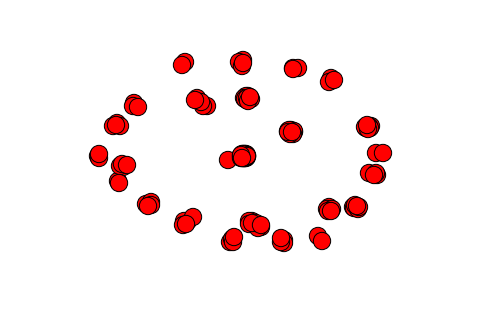

In [56]:
img = nx.draw_spring(graph[0])

In [64]:
edges = [(int(i['source']),int(i['target'])) for i in graph[1]['links']]

In [112]:
pos = nx.layout.random_layout(g)

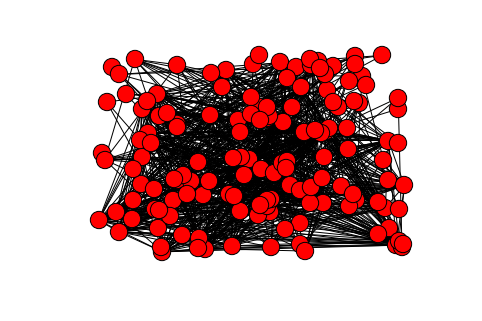

In [113]:
nx.draw(g, pos)